In [1]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import regularizers
from keras.layers import SpatialDropout1D, Dense, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
from ast import literal_eval
from scipy.stats.stats import pearsonr
import nltk
# Download glove vectors at https://www.kaggle.com/yutanakamura/glove42b300dtxt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# 1. Data Cleaning & Feature Extraction

In [2]:
# Import dataset
df = pd.read_csv("cleaned_dataset_with_labels.csv")
df = df.rename(columns={"Unnamed: 0": "id"})
df.head()

,id,enthusiasm,urgency,surprise,trust,curiosity,exclusivity,dominant topic,sum,subject lines
0,0,0.999359,0.000060,0.000215,0.000223,0.000097,0.000045,enthusiasm,1.0,Event for Freshmen: Discover career opportunit...
1,1,0.557934,0.000166,0.000486,0.000392,0.426178,0.014844,enthusiasm,1.0,Complete your setup with the Slack desktop app
2,2,0.980376,0.001827,0.003076,0.008313,0.001398,0.005011,enthusiasm,1.0,Are you ready to play?
3,3,0.000100,0.000218,0.666365,0.000144,0.333089,0.000083,surprise,1.0,"Gadabout - plus, Go behind the scenes of our n..."
4,4,0.000601,0.000160,0.000038,0.000133,0.000259,0.998810,exclusivity,1.0,General Registration is now open for Winter/Sp...


In [3]:
# Clean the subject lines
df['subject lines'] = df['subject lines'].str.lower()
df['subject lines'] = df['subject lines'].str.replace('\r',' ')
df['subject lines'] = df['subject lines'].str.replace('[^\w\s]',' ')

df = df.fillna(0)
df.head()

,id,enthusiasm,urgency,surprise,trust,curiosity,exclusivity,dominant topic,sum,subject lines
0,0,0.999359,0.000060,0.000215,0.000223,0.000097,0.000045,enthusiasm,1.0,event for freshmen discover career opportunit...
1,1,0.557934,0.000166,0.000486,0.000392,0.426178,0.014844,enthusiasm,1.0,complete your setup with the slack desktop app
2,2,0.980376,0.001827,0.003076,0.008313,0.001398,0.005011,enthusiasm,1.0,are you ready to play
3,3,0.000100,0.000218,0.666365,0.000144,0.333089,0.000083,surprise,1.0,gadabout plus go behind the scenes of our n...
4,4,0.000601,0.000160,0.000038,0.000133,0.000259,0.998810,exclusivity,1.0,general registration is now open for winter sp...


In [4]:
# Check for null values
df.isnull().values.any()

False

In [5]:
# Create X and Y and split training and test sets
x = df['subject lines'].values
y = df[['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity']].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 2. Tokenization and Creation of GloVe Embeddings

In [6]:
# Tokenize the words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x)
words_to_index = tokenizer.word_index
len(words_to_index)

12272

In [7]:
# Overview of word_to_index
list(words_to_index.items())[:10]

[('to', 1),
 ('the', 2),
 ('for', 3),
 ('your', 4),
 ('and', 5),
 ('off', 6),
 ('you', 7),
 ('a', 8),
 ('in', 9),
 ('on', 10)]

In [8]:
# Pad the sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
x_train_indices = pad_sequences(train_sequences, padding='post', maxlen=25)
test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_indices = pad_sequences(test_sequences, padding='post', maxlen=25)

In [9]:
# Read GloVe vectors
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

word_to_vec_map = read_glove_vector('glove.42b.300d.txt')

In [10]:
# Create embedding layer
vocab_len = len(words_to_index)
emb_dim = 300
input_shape=(25, )
hits = 0
misses = 0
miss_list = []

emb_matrix = np.zeros((vocab_len, emb_dim))

for word, i in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[i-1, :] = embedding_vector
        hits += 1
    else:
        miss_list.append(word)
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 11458 words (814 misses)


In [11]:
# Overview of emb_matrix
emb_matrix.shape

(12272, 300)

In [12]:
# Overview of the list of words without vectors
miss_list[:5]

['covid', 'savinay', 'airism', 'blaw168', 'doordash']

# 3. Convolutional Neural Network (CNN) Model

In [13]:
# CNN model creation
emb_layer = Embedding(vocab_len, emb_dim, input_shape=input_shape, weights=[emb_matrix], trainable=False)
keras.backend.clear_session()
cnn_model = keras.Sequential()
cnn_model.add(emb_layer)
cnn_model.add(Conv1D(250, 3, padding='valid', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(75, activation="relu"))
cnn_model.add(Dense(6, activation="softmax", kernel_regularizer=regularizers.l2(0.2)))
cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           3681600   
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 250)           225250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 75)                18825     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 4

In [14]:
# Overview of x-train
x_train_indices

array([[  46,    6,  817, ...,    0,    0,    0],
       [ 178,   71,    7, ...,    0,    0,    0],
       [   4,  310,  198, ...,    0,    0,    0],
       ...,
       [  69,  120,  163, ...,    0,    0,    0],
       [   4,  360, 1816, ...,    0,    0,    0],
       [  11, 3055,   32, ...,    0,    0,    0]])

In [15]:
# Overview of y-train
y_train

array([[9.98167705e-01, 3.13956713e-04, 6.13841779e-05, 4.30674992e-05,
        5.58753330e-05, 1.35801157e-03],
       [1.32735022e-04, 2.04464888e-04, 2.63601012e-05, 1.27147395e-04,
        8.91534669e-01, 1.07974623e-01],
       [9.99114601e-01, 1.25403482e-04, 2.46416220e-04, 2.41706354e-04,
        2.48847768e-04, 2.30254323e-05],
       ...,
       [6.63114541e-01, 9.89245280e-06, 3.17986032e-05, 4.77318325e-05,
        3.36785706e-01, 1.03305429e-05],
       [7.62451830e-05, 3.86041053e-06, 9.99476285e-01, 3.69914867e-05,
        4.02394500e-04, 4.22363342e-06],
       [3.60871634e-03, 2.64362168e-03, 2.52466904e-03, 9.80666453e-01,
        4.66268269e-03, 5.89385677e-03]])

In [16]:
# Fit the CNN model and stop at minimum validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history_1 = cnn_model.fit(x_train_indices, y_train, validation_split=0.1, batch_size=64, epochs=50, shuffle=False, verbose=0, callbacks=[es])

In [17]:
# Overview of predictions
# Sample of emotions 
y_pred = cnn_model.predict(x_test_indices)
y_pred

array([[0.25150675, 0.02766248, 0.4038386 , 0.0453627 , 0.17756855,
        0.09406092],
       [0.6464783 , 0.05803575, 0.03601474, 0.12878765, 0.09133627,
        0.03934726],
       [0.24555527, 0.16704741, 0.15067184, 0.13024996, 0.12006274,
        0.18641274],
       ...,
       [0.09955672, 0.04329385, 0.07719274, 0.09585725, 0.64992267,
        0.03417675],
       [0.13095611, 0.06291868, 0.07453298, 0.05712515, 0.06143445,
        0.61303264],
       [0.00664688, 0.32794467, 0.08586372, 0.00489476, 0.00422651,
        0.5704235 ]], dtype=float32)

In [18]:
# Overview of y-test to compare with y-pred
y_test

array([[8.99590441e-05, 1.86368191e-04, 7.86958011e-05, 6.08857234e-05,
        9.99185812e-01, 3.98279281e-04],
       [9.98611842e-01, 3.11038625e-04, 2.69014258e-04, 1.52454459e-04,
        2.96644024e-04, 3.59007065e-04],
       [9.98887636e-01, 3.15152687e-05, 3.59425853e-05, 3.46110507e-05,
        3.71363598e-05, 9.73159074e-04],
       ...,
       [5.01082012e-04, 4.45748935e-04, 5.07992339e-04, 4.89282055e-04,
        9.97568347e-01, 4.87547795e-04],
       [3.47483350e-05, 3.08905834e-05, 6.88526367e-04, 3.39252255e-05,
        9.99178105e-01, 3.38042715e-05],
       [6.60543694e-04, 9.91801645e-01, 6.27379198e-04, 1.37284411e-04,
        1.30651348e-04, 6.64249610e-03]])

In [19]:
# Calculate the loss and accuracy of CNN model
cnn_accr = cnn_model.evaluate(x_test_indices, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(cnn_accr[0], cnn_accr[1]))

103/103 [==============================] - 0s 2ms/step - loss: 1.2373 - accuracy: 0.5841
Test set
  Loss: 1.237
  Accuracy: 0.584


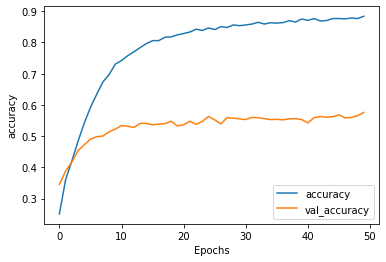

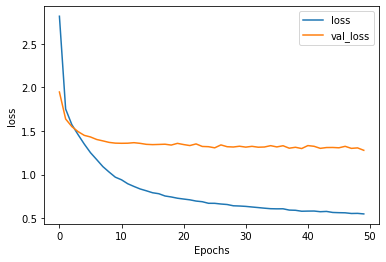

In [20]:
# Plot the loss and accuracy for CNN model
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

In [21]:
# Determine the Pearson correlation coefficient for CNN model
def pearson_correlation(y_pred, y_test):
    pred_list = []
    test_list = []
    results = []
    for i in range(6):
        pred_list.append([item[i] for item in y_pred])
        test_list.append([item[i] for item in y_test])
    for i in range(6):
        results.append(pearsonr(pred_list[i], test_list[i])[0])
    return results
cnn_coeffs = dict(zip(['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity'], pearson_correlation(y_pred, y_test)))
cnn_coeffs

{'enthusiasm': 0.5843029812268206,
 'urgency': 0.7150475451929973,
 'surprise': 0.6175257671564813,
 'trust': 0.5634586995903543,
 'curiosity': 0.6183064992282331,
 'exclusivity': 0.6175995903170342}

# 4. Long Short-Term Memory (LSTM) Model

In [22]:
# LSTM model creation
keras.backend.clear_session()
lstm_model = keras.Sequential()
lstm_model.add(emb_layer)
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(6, activation="softmax", kernel_regularizer=regularizers.l2(0.1)))
lstm_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           3681600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               541200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1806      
Total params: 4,224,606
Trainable params: 543,006
Non-trainable params: 3,681,600
_________________________________________________________________


In [23]:
# Fit the LSTM model
history_2 = lstm_model.fit(x_train_indices, y_train, validation_split=0.1, batch_size=32, epochs=25, shuffle=False, verbose=0, callbacks=[es])

In [24]:
# Calculate the loss and accuracy of LSTM model
lstm_accr = lstm_model.evaluate(x_test_indices, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(lstm_accr[0], lstm_accr[1]))

103/103 [==============================] - 2s 15ms/step - loss: 1.4351 - accuracy: 0.5212
Test set
  Loss: 1.435
  Accuracy: 0.521


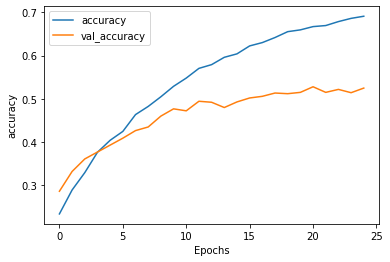

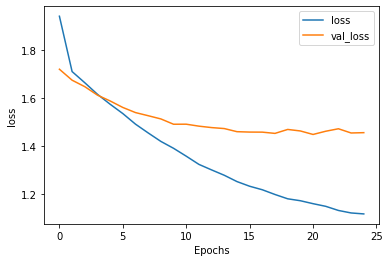

In [25]:
# Plot the loss and accuracy for LSTM model
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

In [26]:
# Determine the Pearson correlation coefficient for LSTM model
y_pred_1 = lstm_model.predict(x_test_indices)
lstm_coeffs = dict(zip(['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity'], pearson_correlation(y_pred_1, y_test)))
lstm_coeffs

{'enthusiasm': 0.49260424365066213,
 'urgency': 0.6349636660907001,
 'surprise': 0.5277270073968747,
 'trust': 0.4590896560360299,
 'curiosity': 0.5614093498719933,
 'exclusivity': 0.527883348573159}

In [27]:
# Create helper function for prediction of single subject line
def emotion_predict(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]","", text)
    text_sequence = tokenizer.texts_to_sequences([text])
    text_indices = pad_sequences(text_sequence, padding='post', maxlen=25)
    return cnn_model.predict(text_indices)[0]
emotion_predict("How do you like our new product")

array([0.07563805, 0.02218321, 0.03001073, 0.04825941, 0.09464573,
       0.7292629 ], dtype=float32)